## Question 1

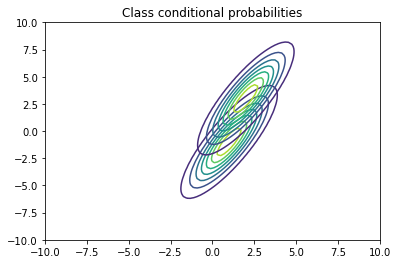

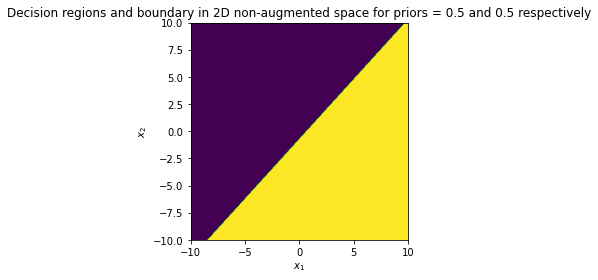

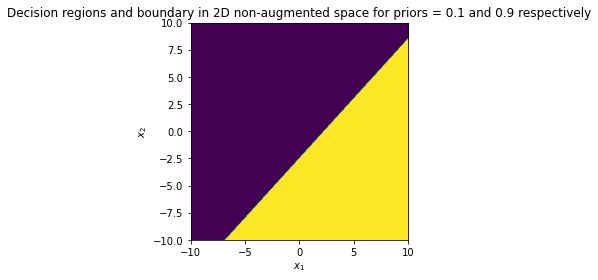

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


def generate_distributions(mean_1, mean_2, cov):
    px_s1 = stats.multivariate_normal(mean_1, cov)
    px_s2 = stats.multivariate_normal(mean_2, cov)
    x, y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
    plt.contour(x, y, px_s1.pdf(np.dstack((x, y))), cmap = 'viridis')
    plt.contour(x, y, px_s2.pdf(np.dstack((x, y))), cmap = 'viridis')
    plt.title('Class conditional probabilities')
    plt.show()

def plotter(mean1, mean2, cov, prior1, prior2):
    x_max = 10
    y_max = 10
    x_min = -10
    y_min = -10
    
    inc = 0.05
    
    (x, y) = np.meshgrid(np.arange(x_min, x_max + inc/100, inc),
                        np.arange(y_min, y_max + inc/100, inc))
    
    xy = np.hstack((x.reshape(x.shape[0] * x.shape[1], 1),
                    y.reshape(y.shape[0] * y.shape[1], 1)))
    
    prod1 = (stats.multivariate_normal(mean1, cov)).pdf(xy) * prior1
    prod2 = (stats.multivariate_normal(mean2, cov)).pdf(xy) * prior2
    
    dec_region = ((prod1 - prod2) > 0).reshape(x.shape)
    
    plt.imshow(dec_region, extent = [x_min, x_max, y_min, y_max], origin = 'lower')
    plt.title(f'Decision regions and boundary in 2D non-augmented space for priors = {prior1} and {prior2} respectively')
    plt.xlabel('$x_1$'), plt.ylabel('$x_2$')
    plt.show()

if __name__ == '__main__':
    mean_1 = [1, -1]
    mean_2 = [2, 3]
    covariance = [[2, 3],[3, 6.5]]
    generate_distributions(mean_1, mean_2, covariance)
    plotter(mean_1, mean_2, covariance, 0.5, 0.5)
    plotter(mean_1, mean_2, covariance, 0.1, 0.9)

## Question 2

Current h : 0.5


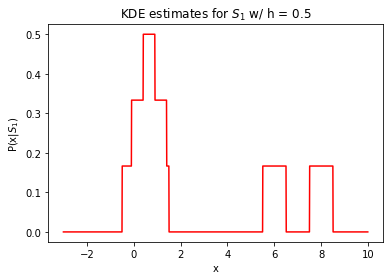

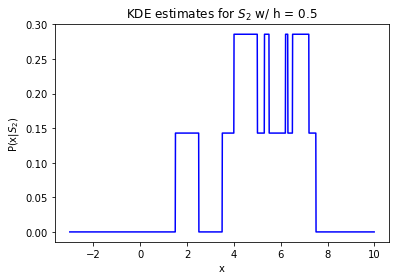

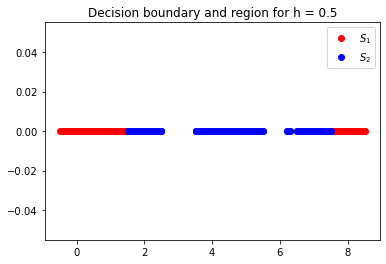

Current h : 1


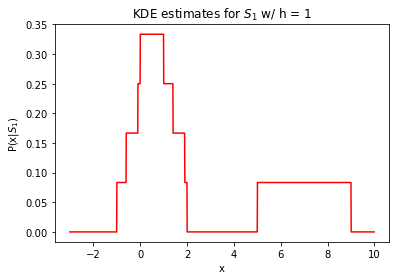

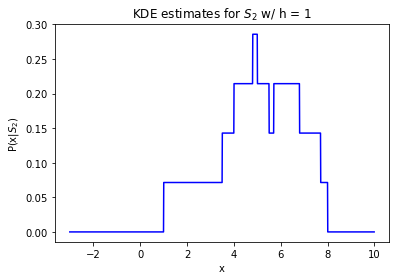

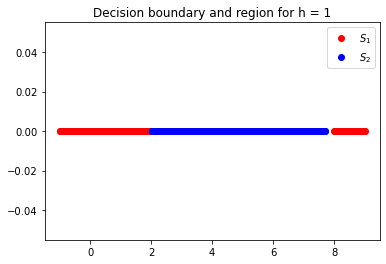

Current h : 2


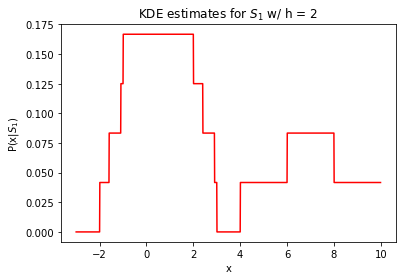

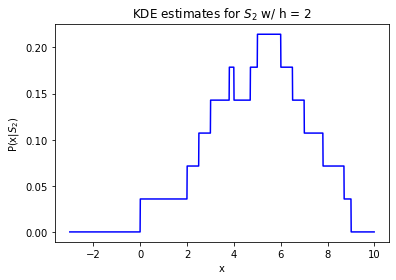

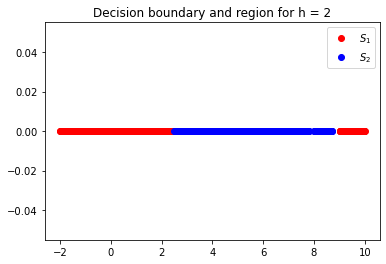

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def prob(idx, h, d, pts):
    if idx >= (pts - h) and idx <= (pts + h):
        return d
    else:
        return 0

def kde(x, h):
    d = 1/(2*h*len(x))
    y = []
    for idx in np.arange(-3, 10, 0.01):
        probability = 0.0
        for pts in x:
            probability += prob(idx, h, d, pts)
        y.append(probability)
    return np.array(y)


def kde_estimate(data, h):
    priors = {k: len(v) for k, v in data.items()}
    prod_1 = priors['S1']*kde(data['S1'], h)
    prod_2 = priors['S2']*kde(data['S2'], h)
    density = np.zeros(np.arange(-3, 10, 0.01).shape)
    density[np.where((prod_1 == prod_2))] = -1
    density[np.where((prod_1 > prod_2))] = 1
    density[np.where((prod_1 < prod_2))] = 0
    return density
    
        
if __name__ == '__main__':
    x1 = [0, 0.4, 0.9, 1, 6, 8]
    x2 = [2.0, 4.0, 4.5, 5.0, 5.8, 6.7, 7.0]
    x_axis = np.arange(-3, 10, 0.01)
    for h in [0.5, 1, 2]:
        print(f"Current h : {h}")
        density = kde_estimate({'S1': x1, 'S2': x2}, h)
        plt.plot(x_axis, kde(x1, h), 'r')
        plt.title(f'KDE estimates for $S_1$ w/ h = {str(h)}'), plt.xlabel('x'), plt.ylabel('P(x|$S_1$)')
        plt.show()
        plt.plot(x_axis, kde(x2, h), 'b')
        plt.title(f'KDE estimates for $S_2$ w/ h = {str(h)}'), plt.xlabel('x'), plt.ylabel('P(x|$S_2$)')
        plt.show()
        plt.plot(x_axis[density == 1], np.zeros(x_axis[density == 1].shape), 'ro', label = '$S_1$')
        plt.plot(x_axis[density == 0], np.zeros(x_axis[density == 0].shape), 'bo', label = '$S_2$')
        plt.legend()
        plt.title(f'Decision boundary and region for h = {str(h)}')
        plt.show()

## Question 3

In [3]:
import numpy as np


class KNNRegressor:
    def __init__(self, x, y, true_target, q = 'a', nbd = 4):
        self.x = x
        self.y = y
        self.nbd = nbd
        self.q = q
        self.true = true_target

    def euclidean_dist(self, x1, x2):
        return np.sqrt(np.sum(x1 - x2) ** 2)
    
    def quadratic_poly(self, x1, x2, **kwargs):
        return 1 - (self.euclidean_dist(x1, x2) / kwargs['dmax'])
        
    
    def evaluate(self, test):
        distances = [self.euclidean_dist(test, self.x[pts]) for pts in range(len(self.x))]
        close_pts = np.argsort(distances)
        dmax = distances[close_pts[self.nbd]]
        w = [1 if self.q == 'a' else self.quadratic_poly(test, idx, dmax = dmax)\
             for idx in self.x[close_pts[:self.nbd]]]
        op = np.sum(w * self.y[close_pts[:self.nbd]]) / np.sum(w)
        mse = (self.true(test) - op)**2
        
        return op, mse
        


if __name__ == '__main__':
    x = np.array([-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9])
    y = np.array([0.81, 0.49, 0.25, 0.09, 0.01, 0.01, 0.09, 0.25, 0.49, 0.81])
    knn = KNNRegressor(x, y, lambda x:x**2)
    test = np.array([0, 0.4])
    total_mse = 0.0
    for pts in test:
        op, mse_error = knn.evaluate(pts)
        print(f"Output for x_test {pts} is {np.round(op, 4)}")
        total_mse += mse_error
    print(f"Total mse for (b): {np.round(total_mse / len(test), 4)}")
    
    
    total_mse = 0.0
    knn = KNNRegressor(x, y, lambda x:x**2, q = 'b')
    for pts in test:
        op, mse_error = knn.evaluate(pts)
        print(f"Output for x_test {pts} is {np.round(op, 4)}")
        total_mse += mse_error
    print(f"Total mse for (c): {np.round(total_mse / len(test), 4)}")
    
    

Output for x_test 0.0 is 0.05
Output for x_test 0.4 is 0.21
Total mse for (b): 0.0025
Output for x_test 0.0 is 0.0367
Output for x_test 0.4 is 0.1967
Total mse for (c): 0.0013
